
# Training CNN

## Import Modules

In [ ]:
import os
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms

## Connect to Google Drive

In [ ]:
from google.colab import drive

drive.mount('/gdrive')
gdrive_root = '/gdrive/My Drive/Experiments'

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


## Set Hyperparameters

In [ ]:
#########################
max_epoch = 10
learning_rate = 0.001
batch_size = 128
#########################
device = 'cuda'

## Construct Data

In [ ]:
data_dir = os.path.join(gdrive_root, 'MeLearn')

train_dataset = torchvision.datasets.FashionMNIST(root=data_dir, train=True, download=True, transform=transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = torchvision.datasets.FashionMNIST(root=data_dir, train=False, download=True, transform=transforms.ToTensor())
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

classes = ('T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat',
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot')

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## Define a Model

In [ ]:
class Classifier(nn.Module):
  def __init__(self):
    super(Classifier, self).__init__()
    ##################################
    # First 2D convolutional layer, taking in 1 input channel (image),
    # outputting 32 activation maps, with a square kernel size of 3
    self.conv1 = nn.Conv2d(1, 32, 3)
    # Second 2D convolutional layer, taking in the 32 input channel,
    # outputting 64 activation maps, with a square kernel size of 3
    self.conv2 = nn.Conv2d(32, 64, 3)

    #For regularization, using dropout layers
    self.dropout1 = nn.Dropout2d(0.25)
    self.dropout2 = nn.Dropout2d(0.5)

    # First fully connected layer
    self.fc1 = nn.Linear(9216, 128)
    # Second fully connected layer that outputs our 10 labels
    self.fc2 = nn.Linear(128, 10)
    ##################################

  def forward(self, x):
    ##################################
    # stack the components
    # Pass data through conv1 with the ReLU activation function
    x = self.conv1(x)
    x = F.relu(x)

    # Passing through conv2 with the ReLU activation function
    x = self.conv2(x)
    x = F.relu(x)
    # Run max pooling over x
    x = F.max_pool2d(x, 2)

    # Pass data through dropout1
    x = self.dropout1(x)

    # Flatten x
    x = torch.flatten(x, 1)

    # Pass data through fc1 with the ReLU
    x = self.fc1(x)
    x = F.relu(x)
    # Pass data through dropout2
    x = self.dropout2(x)

    # Pass data through fc2
    output = self.fc2(x)
    ##################################
    return output

## Initilize the model and optimizer

In [ ]:
model = Classifier().to(device)
print('Model Structure')
print(model)

softmax_cce = nn.CrossEntropyLoss(reduction='sum')
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

Model Structure
Classifier(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout2d(p=0.25, inplace=False)
  (dropout2): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


## Define the Training Procedure

In [ ]:
train_loss_history = []
def train(epoch):
  model.train()
  train_loss = 0
  train_accuracy = 0
  for i, (x, y) in enumerate(train_loader):
    inputs = x.to(device)
    labels = y.to(device)
    ####################################
    #Setting manually the gradients to 0
    optimizer.zero_grad()
    #Calculate the predicted output
    output = model(inputs)
    #Calculate the loss
    loss = softmax_cce(output, labels)
    train_loss += loss.item()
    #Calculate the accuracy
    pred = output.argmax(dim=1, keepdims=True)
    train_accuracy += pred.eq(labels.view_as(pred)).sum().item()
    #Calculate gradients
    loss.backward()
    #Perform optimzation step
    optimizer.step()
    ####################################

  train_loss /= len(train_loader.dataset)
  train_accuracy /= len(train_loader.dataset)
  print(f'epoch: {epoch}, train loss: {train_loss:.4f}, train accuracy {train_accuracy:.4f}')
  train_loss_history.append(train_loss)

## Define the Testing Procedure

In [ ]:
test_loss_history = []
def test(epoch):
  model.eval()
  test_loss = 0
  test_accuracy = 0
  for i, (x, y) in enumerate(test_loader):
    inputs = x.to(device)
    labels = y.to(device)
    ####################################
    output = model(inputs)
    test_loss += softmax_cce(output, labels).item()
    pred = output.argmax(dim=1, keepdim=True)
    test_accuracy += pred.eq(labels.view_as(pred)).sum().item()
    ####################################
  
  test_loss /= len(test_loader.dataset)
  test_accuracy /= len(test_loader.dataset)
  print(f'epoch: {epoch}, test loss: {test_loss:.4f}, test accuracy {test_accuracy:.4f}')
  test_loss_history.append(test_loss)

## Training the model

In [ ]:
# Training
for epoch in range(max_epoch):
  train(epoch)
  test(epoch)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


epoch: 0, train loss: 0.5693, train accuracy 0.7929
epoch: 0, test loss: 0.3720, test accuracy 0.8638
epoch: 1, train loss: 0.3806, train accuracy 0.8652
epoch: 1, test loss: 0.3104, test accuracy 0.8876
epoch: 2, train loss: 0.3308, train accuracy 0.8809
epoch: 2, test loss: 0.2862, test accuracy 0.8964
epoch: 3, train loss: 0.2984, train accuracy 0.8932
epoch: 3, test loss: 0.2618, test accuracy 0.9038
epoch: 4, train loss: 0.2724, train accuracy 0.9009
epoch: 4, test loss: 0.2540, test accuracy 0.9058
epoch: 5, train loss: 0.2519, train accuracy 0.9080
epoch: 5, test loss: 0.2452, test accuracy 0.9101
epoch: 6, train loss: 0.2337, train accuracy 0.9139
epoch: 6, test loss: 0.2338, test accuracy 0.9145
epoch: 7, train loss: 0.2188, train accuracy 0.9194
epoch: 7, test loss: 0.2250, test accuracy 0.9189
epoch: 8, train loss: 0.2055, train accuracy 0.9245
epoch: 8, test loss: 0.2189, test accuracy 0.9223
epoch: 9, train loss: 0.1937, train accuracy 0.9266
epoch: 9, test loss: 0.2194, t

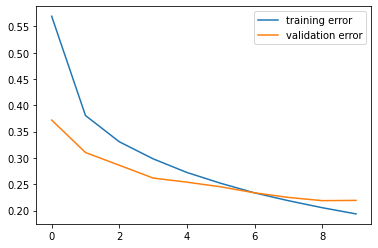

In [ ]:
import matplotlib.pyplot as plt
plt.plot(train_loss_history, label='training error')
plt.plot(test_loss_history, label='validation error')
plt.legend()

## Classify a given data

label : Sandal
prediction : Sandal


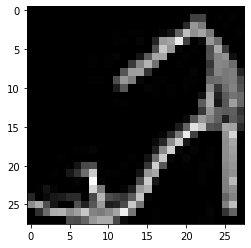

In [ ]:
import random
import numpy as np

model.eval()
random_idx = random.randint(0, len(test_loader.dataset))
test_input, test_label = test_dataset.__getitem__(random_idx)
test_prediction = F.softmax(model(test_input.unsqueeze(0).to(device)), dim=1).argmax().item()
print('label : %s' % classes[test_label])
print('prediction : %s' % classes[test_prediction])

# functions to show an image
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# show images
imshow(torchvision.utils.make_grid(test_input))